In [18]:
import os

os.environ["KERAS_BACKEND"] = "tensorflow"

import numpy as np
import tensorflow as tf
import keras
from keras import ops
from keras import layers

class Sampling(layers.Layer):
    """Uses (z_mean, z_log_var) to sample z, the vector encoding a digit."""

    def __init__(self, **kwargs):
        super().__init__(**kwargs)
        self.seed_generator = keras.random.SeedGenerator(1337)

    def call(self, inputs):
        z_mean, z_log_var = inputs
        batch = ops.shape(z_mean)[0]
        dim = ops.shape(z_mean)[1]
        epsilon = keras.random.normal(shape=(batch, dim), seed=self.seed_generator)
        return z_mean + ops.exp(0.5 * z_log_var) * epsilon
    
latent_dim = 8

# ENCODER
T = 4608
encoder_inputs = keras.Input(shape=(T, 1))  # 1D sequence, single channel
x = layers.Conv1D(32, 3, activation="relu", strides=2, padding="same")(encoder_inputs)
x = layers.Conv1D(64, 3, activation="relu", strides=2, padding="same")(x)
x = layers.Flatten()(x)
x = layers.Dense(128, activation="relu")(x)
z_mean = layers.Dense(latent_dim, name="z_mean")(x)
z_log_var = layers.Dense(latent_dim, name="z_log_var")(x)
z = Sampling()([z_mean, z_log_var])
encoder = keras.Model(encoder_inputs, [z_mean, z_log_var, z], name="encoder")

encoder.summary()

# DECODER
latent_inputs = keras.Input(shape=(latent_dim,))
x = layers.Dense((T // 4) * 64, activation="relu")(latent_inputs)  # match downsampling in encoder
x = layers.Reshape((T // 4, 64))(x)
x = layers.UpSampling1D(2)(x)
x = layers.Conv1D(64, 3, activation="relu", padding="same")(x)
x = layers.UpSampling1D(2)(x)
x = layers.Conv1D(32, 3, activation="relu", padding="same")(x)
decoder_outputs = layers.Conv1D(1, 3, activation="linear", padding="same")(x)
decoder = keras.Model(latent_inputs, decoder_outputs, name="decoder")

decoder.summary()


Model: "encoder"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_4       │ (None, 4608, 1)   │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_10 (Conv1D)  │ (None, 2304, 32)  │        128 │ input_layer_4[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_11 (Conv1D)  │ (None, 1152, 64)  │      6,208 │ conv1d_10[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten_2 (Flatten) │ (None, 73728)     │          0 │ conv1d_11[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_4 (Dense)     │ (None, 128)       │  9,437,312 │ flatten_2[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ z_mean (Dense)      │ (None, 8)         │      1,032 │ dense_4[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ z_log_var (Dense)   │ (None, 8)         │      1,032 │ dense_4[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ sampling_2          │ (None, 8)         │          0 │ z_mean[0][0],     │
│ (Sampling)          │                   │            │ z_log_var[0][0]   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 9,445,712 (36.03 MB)

 Trainable params: 9,445,712 (36.03 MB)

 Non-trainable params: 0 (0.00 B)

Model: "decoder"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_5 (InputLayer)      │ (None, 8)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 73728)          │       663,552 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ reshape_2 (Reshape)             │ (None, 1152, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ up_sampling1d_4 (UpSampling1D)  │ (None, 2304, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_12 (Conv1D)              │ (None, 2304, 64)       │        12,352 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ up_sampling1d_5 (UpSampling1D)  │ (None, 4608, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_13 (Conv1D)              │ (None, 4608, 32)       │         6,176 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_14 (Conv1D)              │ (None, 4608, 1)        │            97 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 682,177 (2.60 MB)

 Trainable params: 682,177 (2.60 MB)

 Non-trainable params: 0 (0.00 B)

In [26]:
class VAE(keras.Model):
    def __init__(self, encoder, decoder, **kwargs):
        super().__init__(**kwargs)
        self.encoder = encoder
        self.decoder = decoder
        self.total_loss_tracker = keras.metrics.Mean(name="total_loss")
        self.reconstruction_loss_tracker = keras.metrics.Mean(
            name="reconstruction_loss"
        )
        self.kl_loss_tracker = keras.metrics.Mean(name="kl_loss")

    @property
    def metrics(self):
        return [
            self.total_loss_tracker,
            self.reconstruction_loss_tracker,
            self.kl_loss_tracker,
        ]

    def train_step(self, data):
        with tf.GradientTape() as tape:
            z_mean, z_log_var, z = self.encoder(data)
            reconstruction = self.decoder(z)
            reconstruction_loss = ops.mean(
                ops.sum(
                    keras.losses.mean_squared_error(data, reconstruction),
                    axis=1,
                )
            )
            kl_loss = -0.5 * (1 + z_log_var - ops.square(z_mean) - ops.exp(z_log_var))
            kl_loss = ops.mean(ops.sum(kl_loss, axis=1))
            total_loss = reconstruction_loss + kl_loss
        grads = tape.gradient(total_loss, self.trainable_weights)
        self.optimizer.apply_gradients(zip(grads, self.trainable_weights))
        self.total_loss_tracker.update_state(total_loss)
        self.reconstruction_loss_tracker.update_state(reconstruction_loss)
        self.kl_loss_tracker.update_state(kl_loss)
        return {
            "loss": self.total_loss_tracker.result(),
            "reconstruction_loss": self.reconstruction_loss_tracker.result(),
            "kl_loss": self.kl_loss_tracker.result(),
        }

In [27]:
# LOAD IN LIGHT CURVES
import os
import numpy as np
from astropy.io import fits
from keras_preprocessing.sequence import pad_sequences

data_dir = "/home/skelly/school/code_nova/astroNN_testing/KL_play_data_100_fits"
fits_files = [f for f in os.listdir(data_dir) if f.endswith("_llc.fits")]

light_curves = []

for f in fits_files:
    path = os.path.join(data_dir, f)
    with fits.open(path) as hdul:
        flux = hdul[1].data['PDCSAP_FLUX']  # adjust column name if needed
        flux = flux[np.isfinite(flux)]       # remove NaNs
        # Optional: normalize per light curve
        flux = (flux - np.mean(flux)) / np.std(flux)
        flux = (flux - np.mean(flux)) / np.std(flux)
        light_curves.append(flux)

# Pad or truncate to a fixed length T (for GRU input)
T = 4608  # choose appropriate length for your data
light_curve_data = pad_sequences(light_curves, maxlen=T, dtype='float32', padding='post', truncating='post')

# Add channel dimension (time × 1)
light_curve_data = np.expand_dims(light_curve_data, -1)  # shape: (num_curves, T, 1)

print("Light curve data shape:", light_curve_data.shape)

Light curve data shape: (92, 4608, 1)


In [29]:
import matplotlib.pyplot as plt
import numpy as np

def plot_reconstructions(model, data, n=5):
    """
    Plots n original and reconstructed light curves.
    
    model: trained VAE
    data: your mnist_like_data (shape: num_curves x T x 1)
    n: number of curves to visualize
    """
    idxs = np.random.choice(len(data), n, replace=False)
    reconstructed = model.decoder(model.encoder(data[idxs])[2]).numpy()  # get z -> decode
    
    plt.figure(figsize=(15, 2*n))
    
    for i, idx in enumerate(idxs):
        plt.subplot(n, 1, i+1)
        plt.plot(data[idx,:,0], label='Original', alpha=0.7)
        plt.plot(reconstructed[i,:,0], label='Reconstructed', alpha=0.5)
        residual = data[idx,:,0] - reconstructed[i,:,0]
        #plt.plot(residual, label='Residual', alpha=0.2)
        plt.title(f"Light curve {idx}")
        plt.xlabel('Time step')
        plt.ylabel('Normalized flux')
        plt.legend()
    
    plt.tight_layout()
    plt.show()


In [30]:
class ReconstructionPlotCallback(tf.keras.callbacks.Callback):
    def __init__(self, data, n=3):
        self.data = data
        self.n = n
    
    def on_epoch_end(self, epoch, logs=None):
        if epoch % 25 == 0:  # plot every 5 epochs
            print(f"\nEpoch {epoch} reconstruction check:")
            plot_reconstructions(self.model, self.data, self.n)


Epoch 1/300
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - kl_loss: 122.1149 - loss: 495.4083 - reconstruction_loss: 373.2934
Epoch 0 reconstruction check:


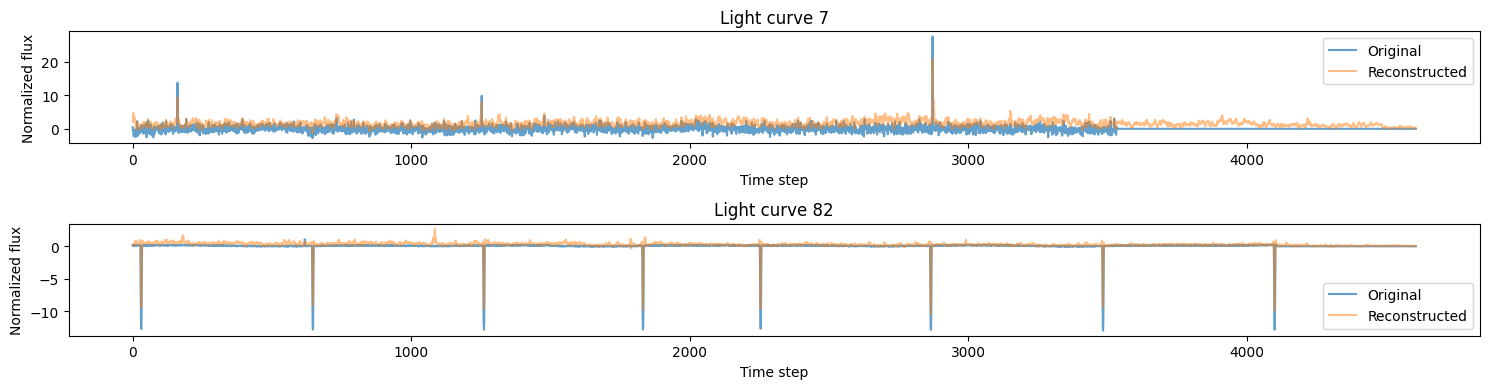

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - kl_loss: 122.1149 - loss: 495.4083 - reconstruction_loss: 373.2934
Epoch 2/300
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 252ms/step - kl_loss: 102.4723 - loss: 5080.9092 - reconstruction_loss: 4978.4370
Epoch 3/300
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 236ms/step - kl_loss: 81.1223 - loss: 1083.0277 - reconstruction_loss: 1001.9055
Epoch 4/300
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 233ms/step - kl_loss: 71.4499 - loss: 1370.5065 - reconstruction_loss: 1299.0566
Epoch 5/300
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 237ms/step - kl_loss: 64.1025 - loss: 2245.4055 - reconstruction_loss: 2181.3030
Epoch 6/300
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 228ms/step - kl_loss: 55.8595 - loss: 1941.3994 - reconstruction_loss: 1885.5399
Epoch 7/300
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 233ms/step - kl_loss: 48.6383 - loss: 1518.0896 - reconstruction_loss: 1469.4513
Epoch 8/300
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 239ms/step - kl_loss: 44.1658 - loss: 1304.7003 - reconstruction_loss: 1260.5345
Epoch 9/300
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 253ms/s

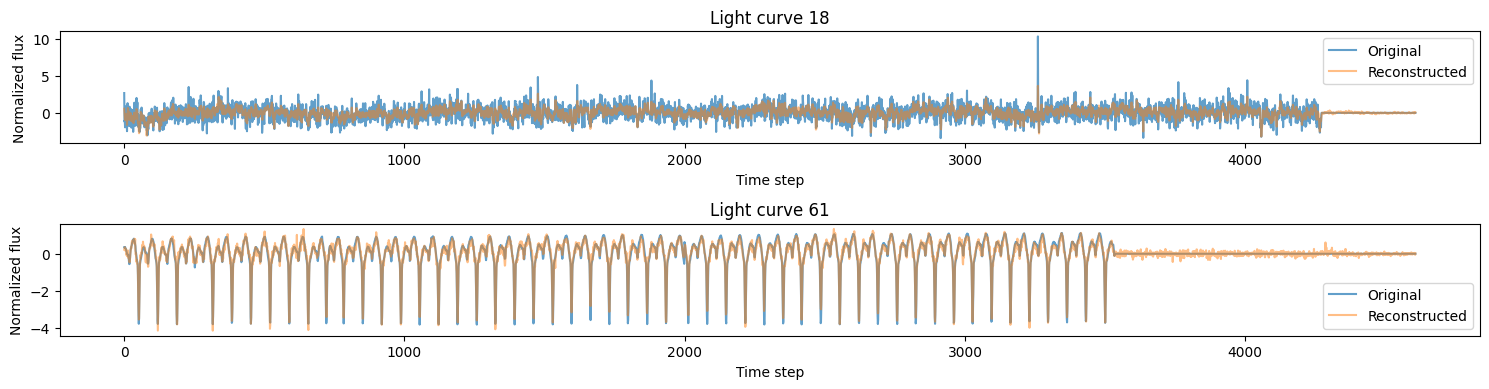

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 493ms/step - kl_loss: 54.6375 - loss: 901.8821 - reconstruction_loss: 847.2446
Epoch 27/300
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 280ms/step - kl_loss: 56.8901 - loss: 868.1967 - reconstruction_loss: 811.3066
Epoch 28/300
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 244ms/step - kl_loss: 59.6217 - loss: 833.9899 - reconstruction_loss: 774.3682
Epoch 29/300
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 245ms/step - kl_loss: 62.6788 - loss: 810.0472 - reconstruction_loss: 747.3683
Epoch 30/300
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 255ms/step - kl_loss: 65.8001 - loss: 788.8948 - reconstruction_loss: 723.0947
Epoch 31/300
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 312ms/step - kl_loss: 68.6600 - loss: 773.0341 - reconstruction_loss: 704.3741
Epoch 32/300
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 380ms/step - kl_loss: 71.0979 - loss: 756.1979 - reconstruction_loss: 685.1000
Epoch 33/300
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 400ms/step - kl_loss: 73.0318 - loss: 731.7914 - reconstruction_loss: 658.7596
Epoch 34/300
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 410ms/step -

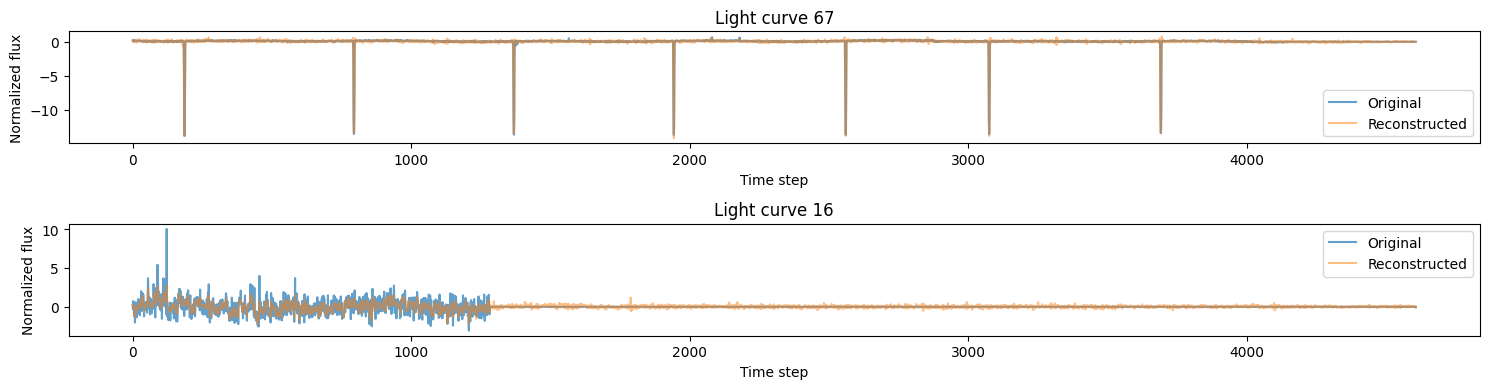

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 455ms/step - kl_loss: 96.1451 - loss: 535.8143 - reconstruction_loss: 439.6692
Epoch 52/300
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 244ms/step - kl_loss: 96.7072 - loss: 531.4602 - reconstruction_loss: 434.7530
Epoch 53/300
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 256ms/step - kl_loss: 97.3137 - loss: 526.5292 - reconstruction_loss: 429.2155
Epoch 54/300
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 250ms/step - kl_loss: 97.9464 - loss: 521.2087 - reconstruction_loss: 423.2622
Epoch 55/300
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 323ms/step - kl_loss: 98.6180 - loss: 515.8201 - reconstruction_loss: 417.2021
Epoch 56/300
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 334ms/step - kl_loss: 99.2372 - loss: 512.0724 - reconstruction_loss: 412.8352
Epoch 57/300
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 317ms/step - kl_loss: 99.7477 - loss: 508.7486 - reconstruction_loss: 409.0009
Epoch 58/300
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 327ms/step - kl_loss: 100.1515 - loss: 504.0258 - reconstruction_loss: 403.8743
Epoch 59/300
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 320ms/step 

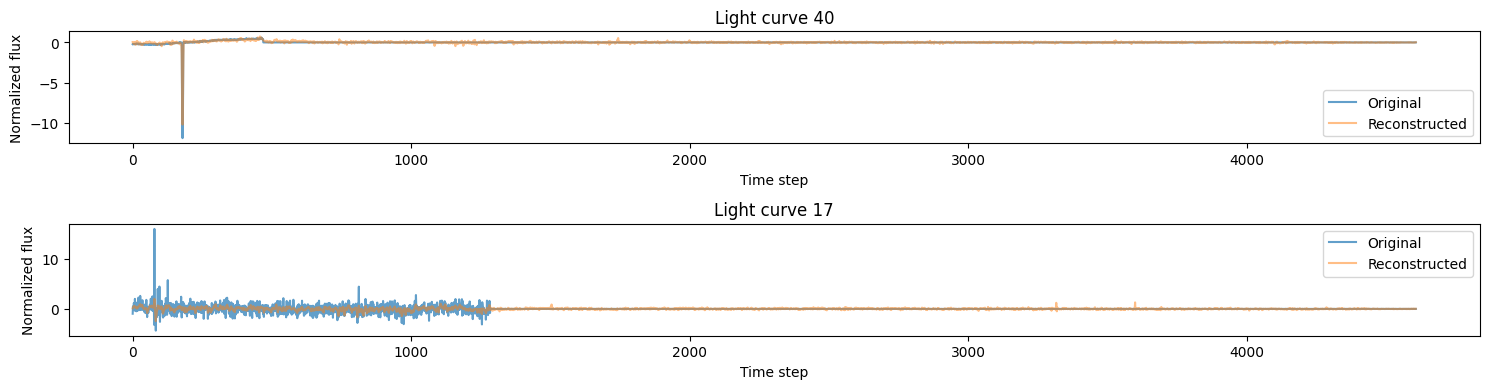

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 580ms/step - kl_loss: 105.6334 - loss: 455.4820 - reconstruction_loss: 349.8486
Epoch 77/300
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 340ms/step - kl_loss: 105.9074 - loss: 453.7359 - reconstruction_loss: 347.8285
Epoch 78/300
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 327ms/step - kl_loss: 106.1501 - loss: 451.1725 - reconstruction_loss: 345.0224
Epoch 79/300
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 355ms/step - kl_loss: 106.2643 - loss: 449.2713 - reconstruction_loss: 343.0070
Epoch 80/300
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 342ms/step - kl_loss: 106.3760 - loss: 447.5952 - reconstruction_loss: 341.2191
Epoch 81/300
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 336ms/step - kl_loss: 106.5250 - loss: 445.8858 - reconstruction_loss: 339.3608
Epoch 82/300
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 335ms/step - kl_loss: 106.7208 - loss: 444.4761 - reconstruction_loss: 337.7553
Epoch 83/300
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 344ms/step - kl_loss: 106.9885 - loss: 442.5977 - reconstruction_loss: 335.6091
Epoch 84/300
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 321m

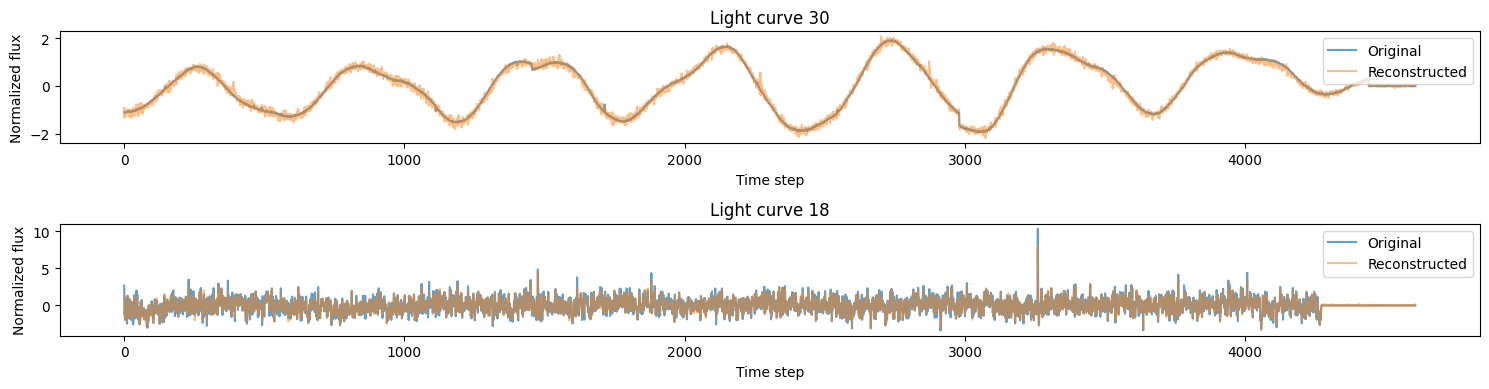

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 971ms/step - kl_loss: 110.1239 - loss: 416.2332 - reconstruction_loss: 306.1093
Epoch 102/300
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 375ms/step - kl_loss: 110.3595 - loss: 415.8962 - reconstruction_loss: 305.5367
Epoch 103/300
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 317ms/step - kl_loss: 110.6116 - loss: 413.2360 - reconstruction_loss: 302.6243
Epoch 104/300
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 294ms/step - kl_loss: 110.8278 - loss: 412.2461 - reconstruction_loss: 301.4183
Epoch 105/300
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 238ms/step - kl_loss: 111.0163 - loss: 410.9995 - reconstruction_loss: 299.9832
Epoch 106/300
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 248ms/step - kl_loss: 111.1492 - loss: 409.6198 - reconstruction_loss: 298.4706
Epoch 107/300
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 248ms/step - kl_loss: 111.2293 - loss: 408.0559 - reconstruction_loss: 296.8266
Epoch 108/300
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 243ms/step - kl_loss: 111.2345 - loss: 407.2794 - reconstruction_loss: 296.0448
Epoch 109/300
1/1 ━━━━━━━━━━━━━━━━━━━━

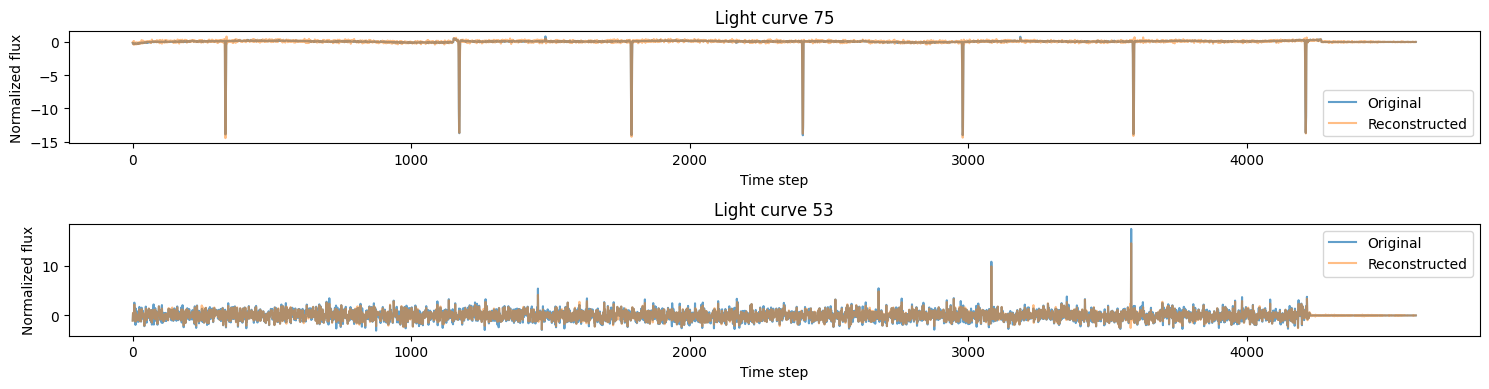

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 486ms/step - kl_loss: 112.2656 - loss: 385.6400 - reconstruction_loss: 273.3744
Epoch 127/300
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 285ms/step - kl_loss: 112.2628 - loss: 384.5016 - reconstruction_loss: 272.2388
Epoch 128/300
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 259ms/step - kl_loss: 112.2615 - loss: 383.8863 - reconstruction_loss: 271.6248
Epoch 129/300
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 253ms/step - kl_loss: 112.3648 - loss: 382.9413 - reconstruction_loss: 270.5765
Epoch 130/300
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 243ms/step - kl_loss: 112.4071 - loss: 381.5780 - reconstruction_loss: 269.1710
Epoch 131/300
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 252ms/step - kl_loss: 112.4862 - loss: 380.1180 - reconstruction_loss: 267.6318
Epoch 132/300
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 244ms/step - kl_loss: 112.5309 - loss: 379.5043 - reconstruction_loss: 266.9734
Epoch 133/300
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 241ms/step - kl_loss: 112.5027 - loss: 377.9602 - reconstruction_loss: 265.4575
Epoch 134/300
1/1 ━━━━━━━━━━━━━━━━━━━━

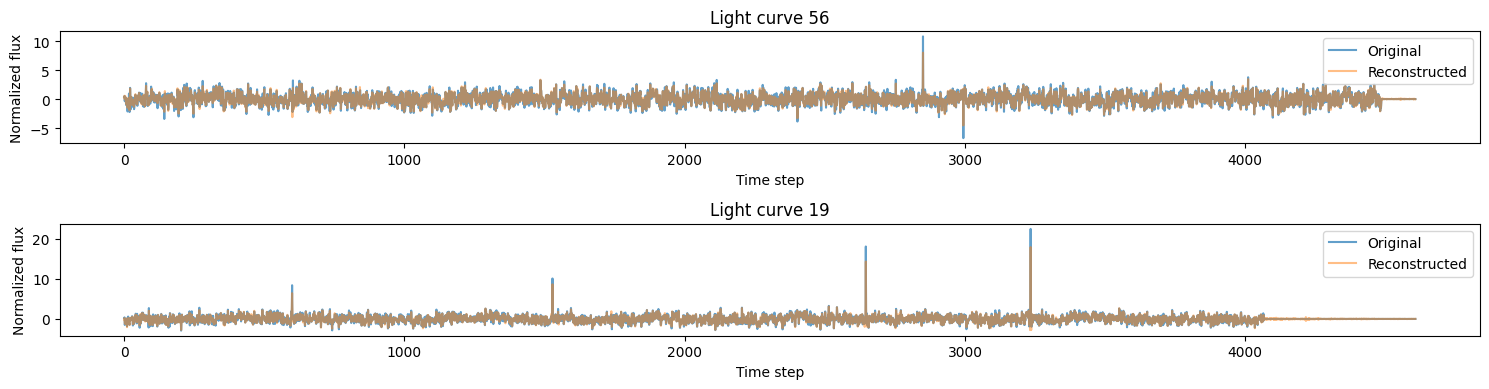

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 625ms/step - kl_loss: 112.2712 - loss: 359.5141 - reconstruction_loss: 247.2429
Epoch 152/300
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 358ms/step - kl_loss: 112.1893 - loss: 357.4899 - reconstruction_loss: 245.3006
Epoch 153/300
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 265ms/step - kl_loss: 112.1209 - loss: 356.8422 - reconstruction_loss: 244.7213
Epoch 154/300
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 255ms/step - kl_loss: 112.1411 - loss: 356.1045 - reconstruction_loss: 243.9634
Epoch 155/300
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 274ms/step - kl_loss: 112.1730 - loss: 355.0172 - reconstruction_loss: 242.8442
Epoch 156/300
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 272ms/step - kl_loss: 112.2160 - loss: 353.8177 - reconstruction_loss: 241.6018
Epoch 157/300
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 272ms/step - kl_loss: 112.2505 - loss: 353.5869 - reconstruction_loss: 241.3364
Epoch 158/300
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 277ms/step - kl_loss: 112.2237 - loss: 352.1956 - reconstruction_loss: 239.9719
Epoch 159/300
1/1 ━━━━━━━━━━━━━━━━━━━━

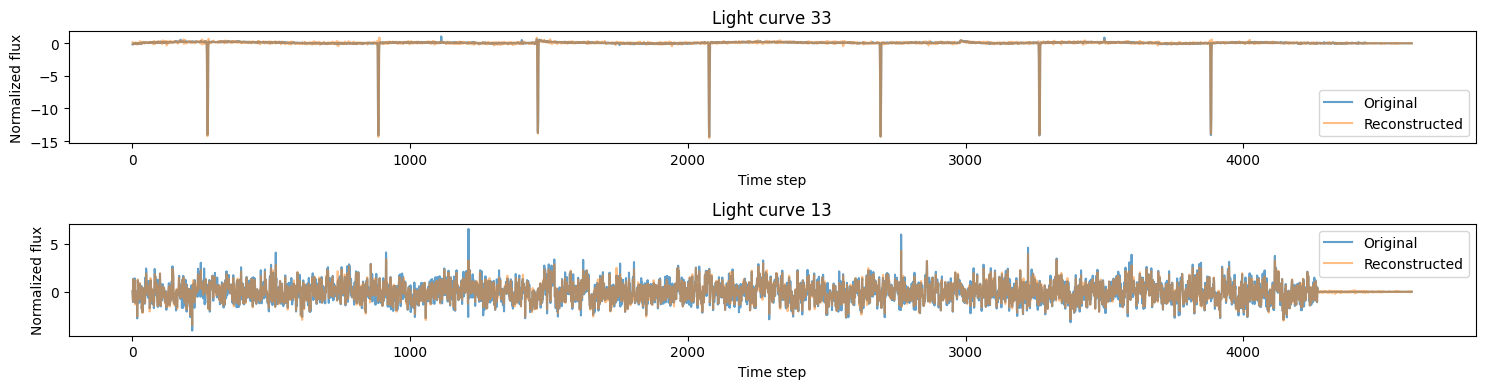

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 606ms/step - kl_loss: 111.0408 - loss: 334.7152 - reconstruction_loss: 223.6745
Epoch 177/300
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 290ms/step - kl_loss: 111.1059 - loss: 334.0970 - reconstruction_loss: 222.9911
Epoch 178/300
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 235ms/step - kl_loss: 111.0214 - loss: 332.0789 - reconstruction_loss: 221.0574
Epoch 179/300
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 236ms/step - kl_loss: 110.8495 - loss: 331.6100 - reconstruction_loss: 220.7605
Epoch 180/300
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 252ms/step - kl_loss: 110.5908 - loss: 330.6445 - reconstruction_loss: 220.0538
Epoch 181/300
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 248ms/step - kl_loss: 110.4108 - loss: 330.2255 - reconstruction_loss: 219.8147
Epoch 182/300
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 241ms/step - kl_loss: 110.3203 - loss: 329.3282 - reconstruction_loss: 219.0079
Epoch 183/300
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 271ms/step - kl_loss: 110.3556 - loss: 328.6262 - reconstruction_loss: 218.2707
Epoch 184/300
1/1 ━━━━━━━━━━━━━━━━━━━━

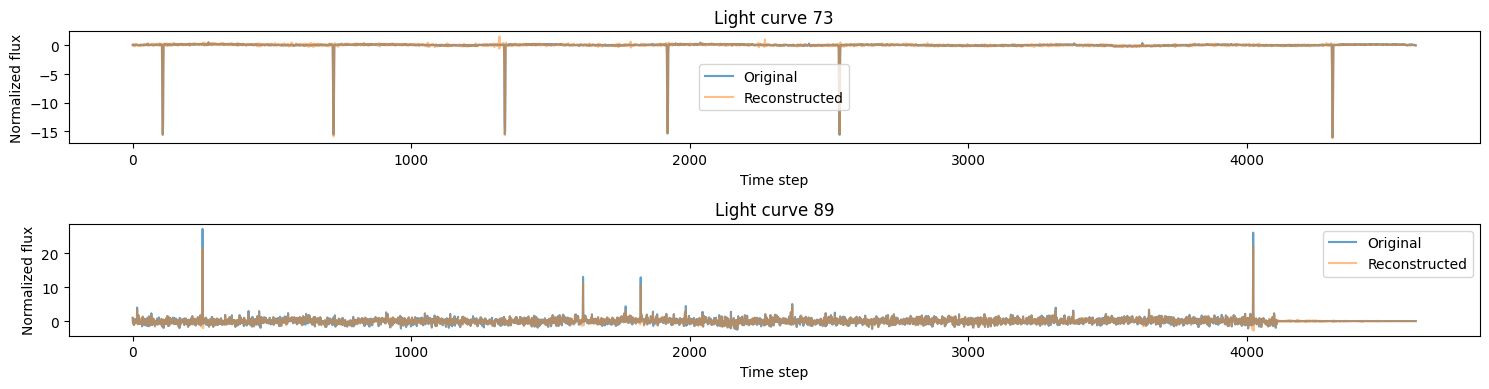

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 472ms/step - kl_loss: 108.8909 - loss: 312.9619 - reconstruction_loss: 204.0710
Epoch 202/300
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 251ms/step - kl_loss: 108.9348 - loss: 312.0637 - reconstruction_loss: 203.1288
Epoch 203/300
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 245ms/step - kl_loss: 108.9770 - loss: 310.6988 - reconstruction_loss: 201.7219
Epoch 204/300
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 238ms/step - kl_loss: 109.0083 - loss: 309.8445 - reconstruction_loss: 200.8362
Epoch 205/300
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 256ms/step - kl_loss: 108.8602 - loss: 309.9181 - reconstruction_loss: 201.0578
Epoch 206/300
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 254ms/step - kl_loss: 108.5730 - loss: 308.6918 - reconstruction_loss: 200.1189
Epoch 207/300
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 331ms/step - kl_loss: 108.4465 - loss: 308.3600 - reconstruction_loss: 199.9135
Epoch 208/300
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 321ms/step - kl_loss: 108.4459 - loss: 306.1413 - reconstruction_loss: 197.6953
Epoch 209/300
1/1 ━━━━━━━━━━━━━━━━━━━━

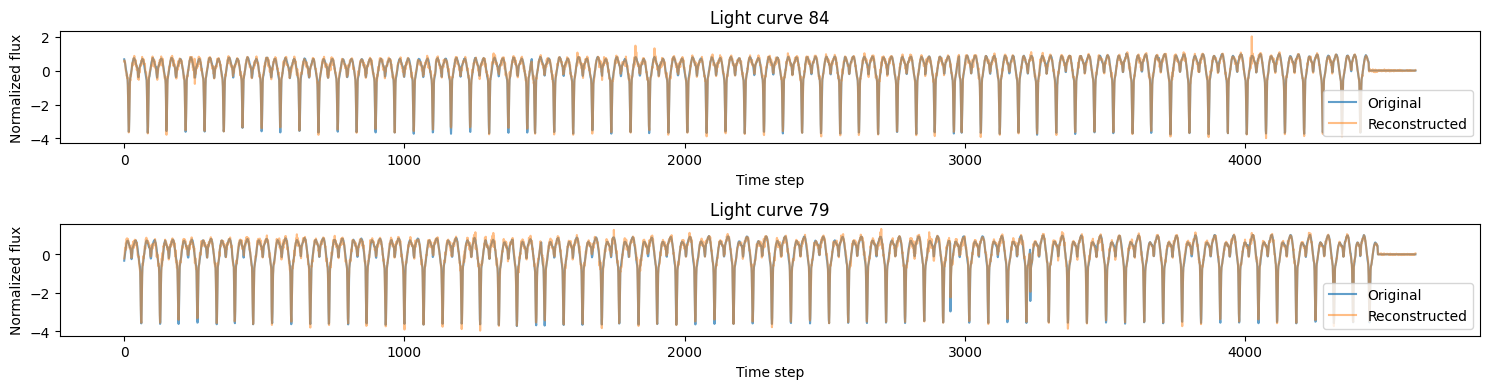

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 483ms/step - kl_loss: 106.3746 - loss: 292.0848 - reconstruction_loss: 185.7103
Epoch 227/300
1/1 ━━━━━━━━━━━━━━━━━━━━ -1s -636836us/step - kl_loss: 106.4873 - loss: 292.3352 - reconstruction_loss: 185.8479
Epoch 228/300
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 339ms/step - kl_loss: 106.3680 - loss: 290.8801 - reconstruction_loss: 184.5121
Epoch 229/300
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 336ms/step - kl_loss: 106.0138 - loss: 289.3265 - reconstruction_loss: 183.3127
Epoch 230/300
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 356ms/step - kl_loss: 105.7670 - loss: 289.3059 - reconstruction_loss: 183.5389
Epoch 231/300
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 268ms/step - kl_loss: 105.6797 - loss: 288.1681 - reconstruction_loss: 182.4884
Epoch 232/300
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 262ms/step - kl_loss: 105.6939 - loss: 287.6397 - reconstruction_loss: 181.9458
Epoch 233/300
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 265ms/step - kl_loss: 105.7695 - loss: 286.5975 - reconstruction_loss: 180.8280
Epoch 234/300
1/1 ━━━━━━━━━━━━━━━

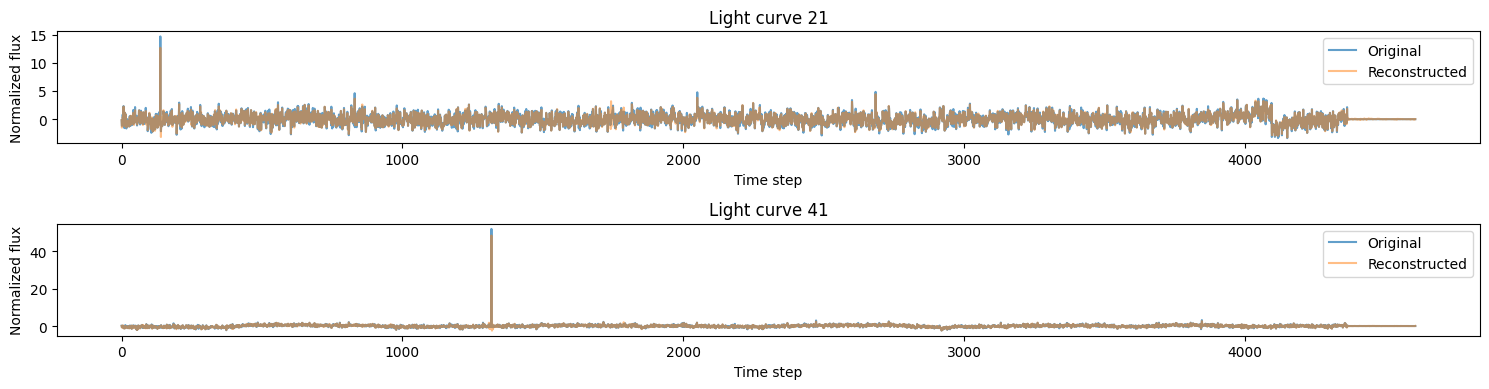

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 495ms/step - kl_loss: 103.5663 - loss: 273.5536 - reconstruction_loss: 169.9873
Epoch 252/300
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 328ms/step - kl_loss: 103.3963 - loss: 273.1969 - reconstruction_loss: 169.8006
Epoch 253/300
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 315ms/step - kl_loss: 103.1927 - loss: 271.6120 - reconstruction_loss: 168.4193
Epoch 254/300
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 349ms/step - kl_loss: 103.0729 - loss: 271.2990 - reconstruction_loss: 168.2261
Epoch 255/300
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 341ms/step - kl_loss: 102.9408 - loss: 270.4939 - reconstruction_loss: 167.5531
Epoch 256/300
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 310ms/step - kl_loss: 102.8526 - loss: 270.4695 - reconstruction_loss: 167.6169
Epoch 257/300
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 303ms/step - kl_loss: 102.8478 - loss: 268.8442 - reconstruction_loss: 165.9964
Epoch 258/300
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 332ms/step - kl_loss: 102.9016 - loss: 268.1111 - reconstruction_loss: 165.2096
Epoch 259/300
1/1 ━━━━━━━━━━━━━━━━━━━━

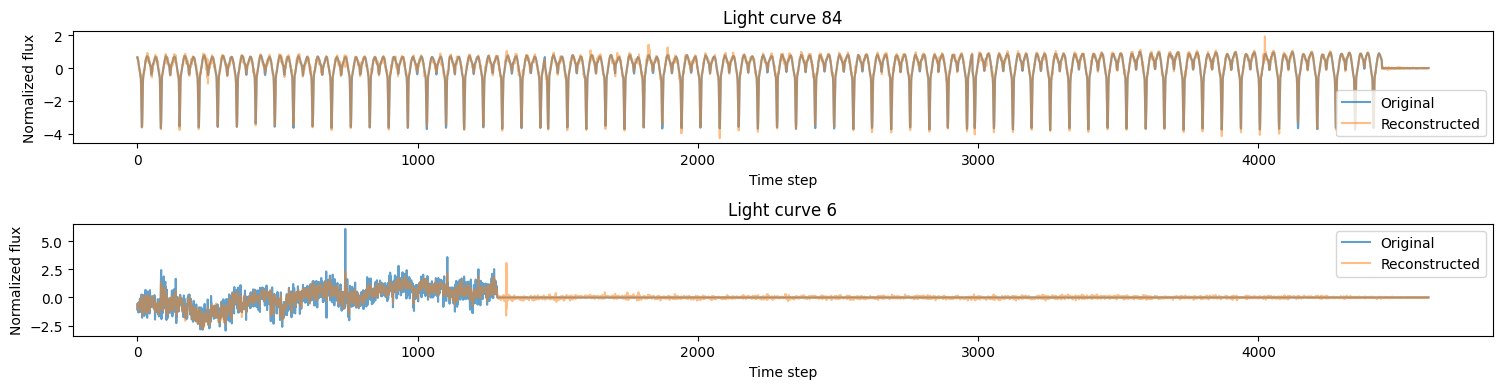

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 663ms/step - kl_loss: 100.6354 - loss: 256.6241 - reconstruction_loss: 155.9887
Epoch 277/300
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 337ms/step - kl_loss: 100.4351 - loss: 255.7676 - reconstruction_loss: 155.3325
Epoch 278/300
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 346ms/step - kl_loss: 100.2391 - loss: 254.3231 - reconstruction_loss: 154.0839
Epoch 279/300
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 352ms/step - kl_loss: 100.0563 - loss: 254.5711 - reconstruction_loss: 154.5148
Epoch 280/300
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 256ms/step - kl_loss: 100.1527 - loss: 254.0210 - reconstruction_loss: 153.8683
Epoch 281/300
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 253ms/step - kl_loss: 100.1801 - loss: 251.9216 - reconstruction_loss: 151.7415
Epoch 282/300
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 232ms/step - kl_loss: 99.9959 - loss: 251.2754 - reconstruction_loss: 151.2794
Epoch 283/300
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 275ms/step - kl_loss: 99.7237 - loss: 251.3438 - reconstruction_loss: 151.6200
Epoch 284/300
1/1 ━━━━━━━━━━━━━━━━━━━━ 0

In [34]:
vae = VAE(encoder, decoder)
vae.compile(optimizer='adam')

history = vae.fit(light_curve_data, epochs=300, batch_size=128, callbacks=[ReconstructionPlotCallback(light_curve_data, n=2)])


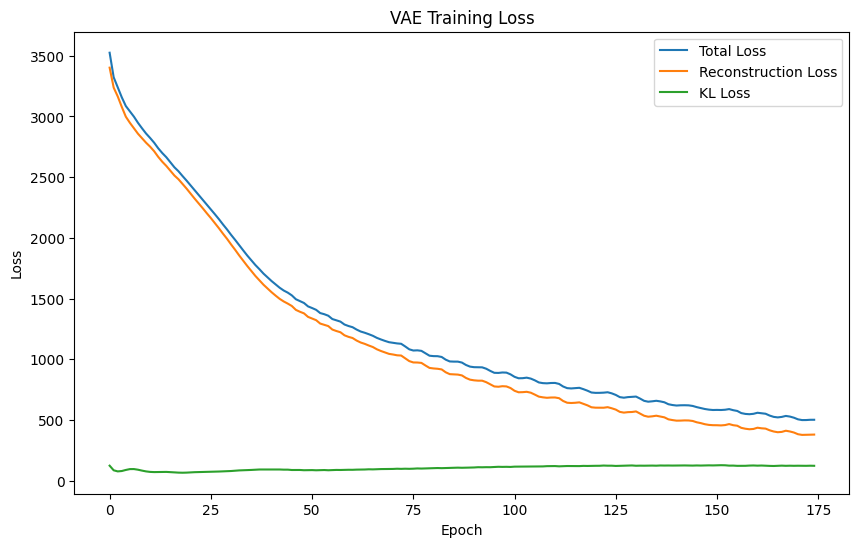

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10,6))
plt.plot(history.history['loss'], label='Total Loss')
plt.plot(history.history['reconstruction_loss'], label='Reconstruction Loss')
plt.plot(history.history['kl_loss'], label='KL Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('VAE Training Loss')
plt.legend()
plt.show()

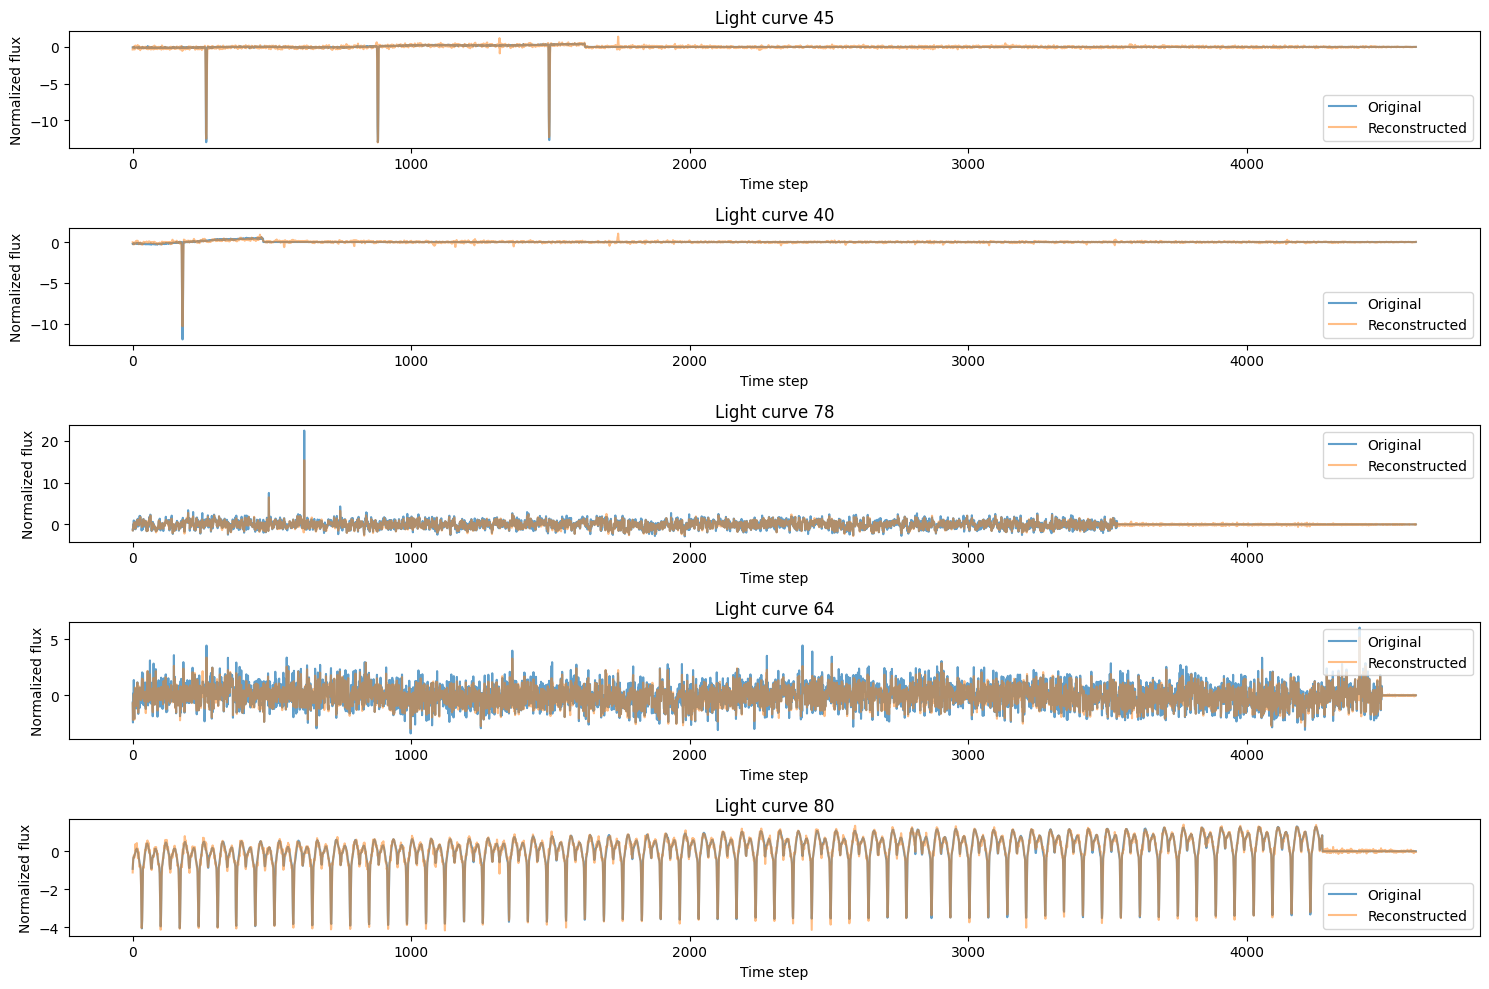

In [33]:
plot_reconstructions(vae, light_curve_data, n=5)